# Introduction

This Notebook allow to create and visualize the dataset for this project.

Some functions was taked from "Visión por computadora" workshop by Mauricio Repetto & Waldemar López 

(https://drive.google.com/file/d/1neqSeyIqdpufL4EtY6jUirUvWGya0Mkp/view?usp=sharing)


# Imports

In [1]:
import numpy as np
import tensorflow as tf
import datetime; 
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sys import stdout
from os import listdir, makedirs, remove
from os.path import isfile, join, isdir, exists, dirname
from tensorflow import keras
from numpy.random import seed
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Project modules below
from lib import util

In [2]:
# Load Inception V3.

InceptionV3      = keras.applications.inception_v3.InceptionV3
preprocess_input = keras.applications.inception_v3.preprocess_input
image            = keras.preprocessing.image


In [3]:
inceptionV3Model = InceptionV3(weights='imagenet', include_top=False, pooling=  'avg')
# Uncomment to describe the inception v3 summary model
#print(inceptionV3Model.summary())

# Setup Util variables And Functions

## Variables

In [4]:
SEED_APP = 123
tf.random.set_seed(SEED_APP)

MOUNT = "./"
DATASET_PATH = join(MOUNT, "dataset/")
RESULT_FOLDER_PATH = join(MOUNT,"result/")

DATESET_BASIC_PATH = join(DATASET_PATH,'basic/')

print(DATESET_BASIC_PATH)

./dataset/basic/


## Functions

In [5]:
def getFolders(path):
    return [d for d in listdir(path) if isdir(join(path, d))]

def getFolderFiles(path: str):
    return [f for f in listdir(path) if isfile(join(path, f))]  


def predict(path: str) -> np.array:
    img = image.load_img(path, target_size=(299, 299))
    # Size  (299, 299, 3)
    imgArray = image.img_to_array(img) 
    
    # Size  (1, 299, 299, 3)
    expandedImgArray = np.expand_dims(imgArray, axis=0) 
    
    # Preproces to inceptionV3, normalize each pixel RGB value to an scale of zero to one
    processedImgArray = preprocess_input(expandedImgArray) 
    
    return inceptionV3Model.predict(processedImgArray)

def getTimestamp():
    return datetime.datetime.now().timestamp()
    
def getRandomExample(xClass:str):

    exampleFileList = getFolderFiles(DATESET_BASIC_PATH + xClass)
    
    rndIndex = np.random.randint(0,len(exampleFileList))
    filename = exampleFileList[rndIndex]
    return join(DATESET_BASIC_PATH,xClass,filename)

def getClasses():
    return getFolders(DATESET_BASIC_PATH)
    
def createFolderIfNotExist(folderPath):
    if not exists(folderPath):
        makedirs(folderPath)

def deleteIfExist(filepath):
    if exists(filepath):
        remove(filepath)

def saveInFileIfNotExist(filepath: str, content: str):
  
    # Create (or not) the result folder
    createFolderIfNotExist(dirname(filepath))
    
    with open(filepath, mode="a") as f:
        f.write(content + '\n')
        

# Observe a single example

In [6]:
np.random.seed(SEED_APP)

CLASSES = getClasses()
RANDOM_POSITIVE_EXAMPLE_PATH = getRandomExample("momo")
RANDOM_POSITIVE_EXAMPLE_FILE = predict(RANDOM_POSITIVE_EXAMPLE_PATH)
print("Momo class random file path" , RANDOM_POSITIVE_EXAMPLE_FILE)

predict(RANDOM_POSITIVE_EXAMPLE_PATH)


Momo class random file path [[0.19734913 0.45167    0.06192229 ... 0.13883413 0.17555334 0.6870728 ]]


array([[0.19734913, 0.45167   , 0.06192229, ..., 0.13883413, 0.17555334,
        0.6870728 ]], dtype=float32)

# Create a CSV to visualize dataset data

In [7]:

CSV_PATH = RESULT_FOLDER_PATH + "basic-predictions/" + str(getTimestamp()) + "/result.csv"

# Write in the file the csv Hheaders
saveInFileIfNotExist(CSV_PATH, "class;image_name;predictions") 

for _class_ in CLASSES:
    classFolderPath = join(DATESET_BASIC_PATH, _class_)
    imagePaths = getFolderFiles(classFolderPath)
    
    print(f"Processing {_class_}...")
    
    for imgName in tqdm(imagePaths, file=stdout):
        imagePath = join(classFolderPath, imgName)
        # Inception V3 return an array of (1,2048)
        predictions = predict(imagePath)
        
        # Get a CSV row for the current class,image and prediction
        csvRow = f'"{_class_}";"{imgName}";"{",".join([ str(pred) for pred in predictions[0]])}"'
        saveInFileIfNotExist(CSV_PATH, csvRow)


Processing meme...
100%|██████████| 60/60 [00:05<00:00, 11.28it/s]
Processing person...
100%|██████████| 88/88 [00:08<00:00, 10.46it/s]
Processing momo...
100%|██████████| 113/113 [00:09<00:00, 12.13it/s]


In [8]:
print("loading csv:" ,CSV_PATH)

# Create dataframe with pandas
df = pd.read_csv(CSV_PATH, sep=';')

# Check the head
df.head()



loading csv: ./result/basic-predictions/1598053082.365445/result.csv


,class,image_name,predictions
0,meme,meme_tmplimage59.jpg,"0.37360469,0.09190824,0.004368141,0.31041825,1..."
1,meme,meme_tmplimage9.jpg,"0.43767205,0.22983317,0.00991118,0.44174778,0...."
2,meme,meme_tmplimage71.jpg,"0.51454926,0.57877517,0.05983212,0.074780315,0..."
3,meme,meme_tmplimage65.jpg,"0.19602767,0.2568739,0.06481302,0.1758996,0.89..."
4,meme,meme_tmplimage70.jpg,"0.069468334,0.4723937,0.16628663,0.09185074,0...."


In [9]:
# Get the predictions as float
df['predictions_float'] = df['predictions'].apply(lambda x: np.array([float(str_dim) for str_dim in x.split(',')], dtype=np.float32))

# Save as np array the predictions per record
vectors = np.array(df['predictions_float'].tolist())

# Print the size (m,2048) where m is the length of our dataset. and 2048 is the predictions
# For each class in inception
print("vectors" , vectors.shape)

folderResults       = dirname(CSV_PATH)
filenameTsvLabels   = folderResults + "/" + "result_labels.tsv" 
filenameTsvEmbdings = folderResults + "/" + "result_embdings.tsv" 

deleteIfExist(filenameTsvLabels)
deleteIfExist(filenameTsvEmbdings)

with open(filenameTsvLabels,'w') as f:
    f.write("Index\tLabel\n")
    for index,(file, label) in enumerate(zip(df.image_name, df["class"])):
        f.write(f'{label} - {file}\t{label}\n')

        
with open(filenameTsvEmbdings,'w') as f:
    for dims in vectors:
        f.write('\t'.join([str(dim) for dim in dims])+'\n')

vectors (261, 2048)


# Visualize the data using tensorflow embding projection

This tool allow to users to visualize him data. Use the last folder in result/basic-predictions/

## Steps

1. Click on Load buttom
2. In step 1 select the file `result_embdings.tsv`
3. In step 2 select the file `result_labels.tsv`
4. Click outside the modal

You should see something like this:

![screenshot using tf embding projector](./docs/tensorflowEmbdingProjector.png)

# PCA 2 dimension Visualization 

In [11]:
# Scaling the data before
vectors_std = StandardScaler().fit_transform(vectors)

In [12]:
vectors[0:10]

array([[3.73604685e-01, 9.19082388e-02, 4.36814083e-03, ...,
        5.88361546e-03, 3.38844806e-01, 2.94581838e-02],
       [4.37672049e-01, 2.29833171e-01, 9.91117954e-03, ...,
        1.14202768e-01, 2.80727208e-01, 2.40652144e-01],
       [5.14549255e-01, 5.78775167e-01, 5.98321185e-02, ...,
        4.11029488e-01, 5.15095770e-01, 2.79301882e-01],
       ...,
       [6.57679066e-02, 1.56305954e-01, 4.48732644e-01, ...,
        1.06274365e-02, 6.69762313e-01, 1.07211709e+00],
       [1.91122770e-01, 2.20589042e-01, 5.84478796e-01, ...,
        2.50498563e-01, 6.63940489e-01, 7.08679259e-01],
       [1.53123602e-01, 1.02330245e-01, 4.17783624e-04, ...,
        3.20425898e-01, 5.95992267e-01, 4.54699323e-02]], dtype=float32)

In [13]:
vectors_std[0:10]

array([[-0.02319396, -1.0774131 , -0.76795363, ..., -1.3777565 ,
        -0.2685194 , -1.1730046 ],
       [ 0.22360897, -0.49110946, -0.7503321 , ..., -1.0720407 ,
        -0.4040858 , -0.46330535],
       [ 0.51975846,  0.9922043 , -0.59163207, ..., -0.23428796,
         0.1426076 , -0.3334262 ],
       ...,
       [-1.2090554 , -0.8036655 ,  0.64469343, ..., -1.3643677 ,
         0.5033863 ,  2.3307614 ],
       [-0.72615826, -0.5304052 ,  1.0762342 , ..., -0.68736446,
         0.48980618,  1.1094599 ],
       [-0.87254024, -1.0331103 , -0.7805119 , ..., -0.49000418,
         0.33130863, -1.1191986 ]], dtype=float32)

In [16]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(vectors_std)
print(principalComponents.shape)
pca.explained_variance_ratio_

(261, 2)


array([0.0723711 , 0.05807094], dtype=float32)

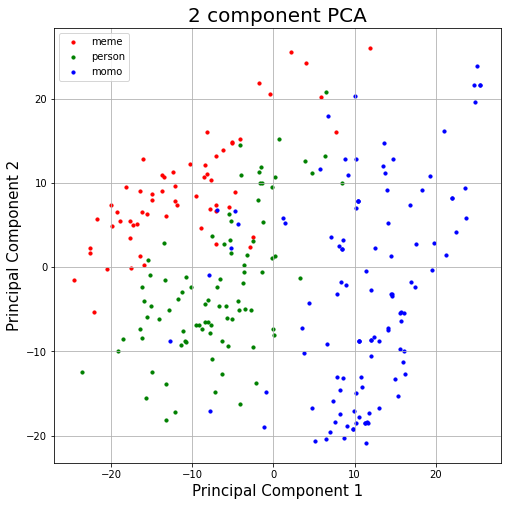

In [19]:
# Plotting using matplot lib

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)

ax.set_title('2 component PCA', fontsize = 20)

targets = getClasses()
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = df['class'] == target    
    ax.scatter(principalComponents[indicesToKeep][:,0:1]
               , principalComponents[indicesToKeep][:,1:2]
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()